# 1. EFFECTIVENESS OF THE ONLINE LEARNING RULE

## Setup the environment

#### Adding the source code path

In [1]:
import sys  
sys.path.insert(1, './../../ESN-IP/IP/.')

In [2]:
import random

random.seed(10)

#### Import experiment data 

In [3]:
from DATA import NARMA10

data = NARMA10(True, [80,10,10])

X_TR, Y_TR = data.TR()
X_VAL, Y_VAL = data.VAL()
X_TS, Y_TS = data.TS()

## NOT PRETRAINED RESERVOIR

In [4]:
N_UNITS = 250

In [5]:
from IPReservoir import IPReservoir
from ESN import Reservoir
from IntrinsicPlasticity import IPMask

simple_reservoir = Reservoir(N = N_UNITS, sparsity=0.9, ro_rescale=0.25, bias = True)

W_x = simple_reservoir.W_x
W_u = simple_reservoir.W_u
b_x = simple_reservoir.b_x
b_u = simple_reservoir.b_u

## PRETRANING WITH OLD STYLE INTRINSIC PLASTICITY

In [6]:
ip_reservoir = IPReservoir(N = N_UNITS, mask=IPMask.normalMask(N_UNITS), bias = True)

ip_reservoir.W_x = W_x
ip_reservoir.W_u = W_u
ip_reservoir.b_x = b_x
ip_reservoir.b_u = b_u

In [14]:
ip_reservoir.pre_train(X_TR, eta=0.0000025, epochs=10,  learning_rule="online", verbose=True) #16

No transient applied. Reservoir was already warmed up
- Epoch: 1) | KL Divergence value: 2562.3203125.
- Epoch: 2) | KL Divergence value: 2553.09375.
- Epoch: 3) | KL Divergence value: 2543.91650390625.
- Epoch: 4) | KL Divergence value: 2534.7861328125.
- Epoch: 5) | KL Divergence value: 2525.70947265625.
- Epoch: 6) | KL Divergence value: 2516.690673828125.
- Epoch: 7) | KL Divergence value: 2507.7294921875.
- Epoch: 8) | KL Divergence value: 2498.817626953125.
- Epoch: 9) | KL Divergence value: 2489.954345703125.
- Epoch: 10) | KL Divergence value: 2481.146240234375.


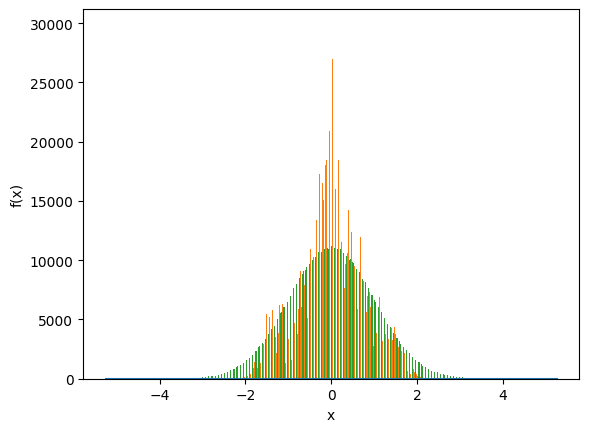

In [23]:
ip_reservoir.predict(X_TR, save_gradients=False, save_states=True)
ip_reservoir.plot_global_neural_activity()

In [ ]:
ip_reservoir.print_IP_stats([0,1])

Unit - (1): [ ACTUAL_MEAN == (1.067537784576416)  ACTUAL_STD == (0.040865570306777954)][ TARGET_MEAN == (-0.002430420368909836) TARGET_STD == (0.9987764954566956)]
Unit - (2): [ ACTUAL_MEAN == (0.5349665880203247)  ACTUAL_STD == (0.06404148787260056)][ TARGET_MEAN == (0.011089984327554703) TARGET_STD == (0.9938219785690308)]
Overall network: [ACTUAL_MEAN == (0.028127899393439293)  ACTUAL_STD == (0.7539604902267456)]


## BIMODAL MIXTURE OF GAUSSIAN

In [24]:
# It seems that switching the "old" bias terms down (input bias and recurrent weights bias), 
# helps the algorithm converging earlier, letting the IP bias dominate the linear translation. 

bimodal_reservoir = IPReservoir(N = N_UNITS, mask=IPMask.mixedBimodalMask(N_UNITS), bias = False)

bimodal_reservoir.W_x = W_x
bimodal_reservoir.W_u = W_u
#bimodal_reservoir.b_x = b_x
#bimodal_reservoir.b_u = b_u

In [72]:
bimodal_reservoir.pre_train(X_TR, eta= 0.00000015, epochs=5,  learning_rule="online", verbose=True)

No transient applied. Reservoir was already warmed up
- Epoch: 1) | KL Divergence value: 1821.8406982421875.
- Epoch: 2) | KL Divergence value: 1822.237060546875.
- Epoch: 3) | KL Divergence value: 1822.7020263671875.
- Epoch: 4) | KL Divergence value: 1823.2391357421875.
- Epoch: 5) | KL Divergence value: 1823.850830078125.


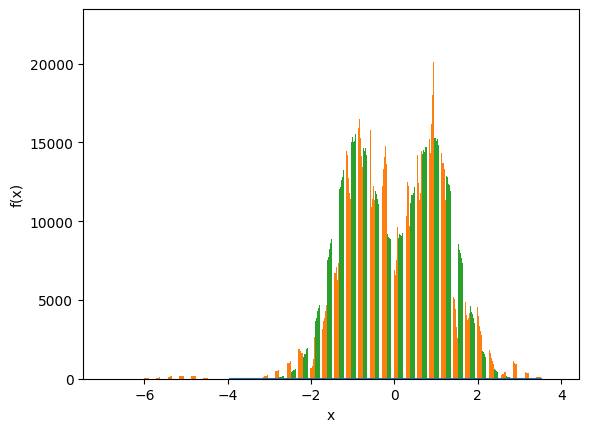

In [73]:
bimodal_reservoir.predict(X_TR, save_gradients=False, save_states=True)
bimodal_reservoir.plot_global_neural_activity()

In [74]:
bimodal_reservoir.print_IP_stats([0,1])

Unit - (1): [ ACTUAL_MEAN == (-0.6443339586257935)  ACTUAL_STD == (0.05066080391407013)][ TARGET_MEAN == (-0.9091352820396423) TARGET_STD == (0.5827725529670715)]
Unit - (2): [ ACTUAL_MEAN == (1.396939754486084)  ACTUAL_STD == (0.0956573635339737)][ TARGET_MEAN == (0.9150592684745789) TARGET_STD == (0.5792074203491211)]
Overall network: [ACTUAL_MEAN == (0.015048532746732235)  ACTUAL_STD == (1.1599682569503784)]


## EVAUALTUION IN ESN

In [75]:
from ESN import EchoStateNetwork

simple_esn = EchoStateNetwork(simple_reservoir)
ip_esn = EchoStateNetwork(ip_reservoir)
bimodal_esn = EchoStateNetwork(bimodal_reservoir)

simple_esn.reservoir.reset_initial_state()
ip_esn.reservoir.reset_initial_state()
bimodal_esn.reservoir.reset_initial_state()

simple_esn.reservoir.warm_up(X_TR[0:100])
ip_esn.reservoir.warm_up(X_TR[0:100])
bimodal_esn.reservoir.warm_up(X_TR[0:100])

simple_esn.train(X_TR[100:None], Y_TR[100:None], 0)
ip_esn.train(X_TR[100:None], Y_TR[100:None], 0)
bimodal_esn.train(X_TR[100:None], Y_TR[100:None], 0)


### COMPARISON ON TEST DATA

In [76]:
from Metrics import NRMSE, MSE

NORMALIZED ROOT-MEAN SQUARE ERROR: 0.02097377973234721


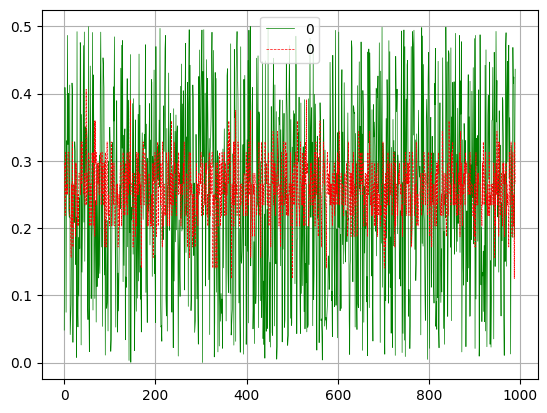

In [77]:
print(f"NORMALIZED ROOT-MEAN SQUARE ERROR: { simple_esn.evaluate(X_TS[10:None], Y_TS[10:None], metric=MSE(), plot=True)}" )

NORMALIZED ROOT-MEAN SQUARE ERROR: 0.02100373509444475


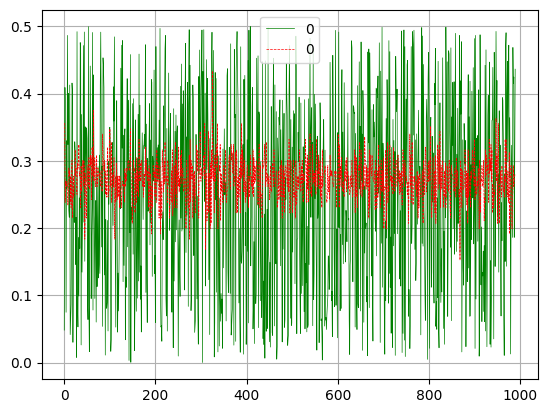

In [78]:
print(f"NORMALIZED ROOT-MEAN SQUARE ERROR: { ip_esn.evaluate(X_TS[10:None], Y_TS[10:None], metric=MSE(), plot=True)}" )

NORMALIZED ROOT-MEAN SQUARE ERROR: 0.02011971200507448


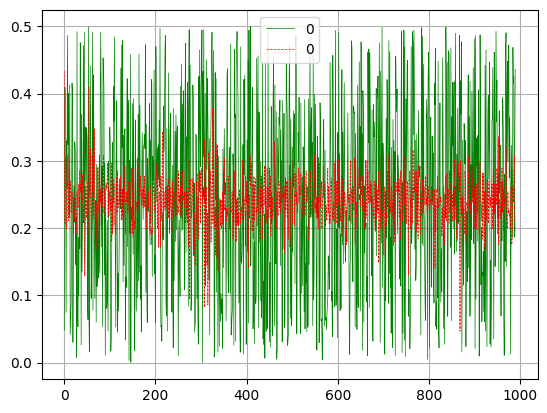

In [79]:
print(f"NORMALIZED ROOT-MEAN SQUARE ERROR: { bimodal_esn.evaluate(X_TS[10:None], Y_TS[10:None], metric=MSE(), plot=True)}" )

## MEMORY CAPACITY

In [80]:
simple_esn.MemoryCapacity(1000,0)

tensor(3.9920)

In [81]:
ip_esn.MemoryCapacity(1000,0)

tensor(8.9350)

In [82]:
bimodal_esn.MemoryCapacity(1000,0)

tensor(2.9133)